## 动量法
使用梯度下降法，每次都会朝着目标函数下降最快的方向，这也称为最速下降法。这种更新方法看似非常快，实际上存在一些问题。

### 梯度下降法的问题
考虑一个二维输入，$[x_1, x_2]$，输出的损失函数 $L: R^2 \rightarrow R$，下面是这个函数的等高线

![avatar](https://camo.githubusercontent.com/4feab406c76995c206b5608d98d6c5e68f233bd9/68747470733a2f2f7773312e73696e61696d672e636e2f6c617267652f303036744b6654636c7931666d6e6b6574773566346a3330617a30346c7133312e6a7067)

可以想象成一个很扁的漏斗，这样在竖直方向上，梯度就非常大，在水平方向上，梯度就相对较小，所以我们在设置学习率的时候就不能设置太大，为了防止竖直方向上参数更新太过了，这样一个较小的学习率又导致了水平方向上参数在更新的时候太过于缓慢，所以就导致最终收敛起来非常慢。

### 动量法
梯度下降法做一个修改如下

$$
v_i = \gamma v_{i-1} + \eta \nabla L(\theta)
$$$$
\theta_i = \theta_{i-1} - v_i
$$
其中 $v_i$ 是当前速度，$\gamma$ 是动量参数，是一个小于 1的正数，$\eta$ 是学习率

相当于每次在进行参数更新的时候，都会将之前的速度考虑进来，每个参数在各方向上的移动幅度不仅取决于当前的梯度，还取决于过去各个梯度在各个方向上是否一致，如果一个梯度一直沿着当前方向进行更新，那么每次更新的幅度就越来越大，如果一个梯度在一个方向上不断变化，那么其更新幅度就会被衰减，这样我们就可以使用一个较大的学习率，使得收敛更快，同时梯度比较大的方向就会因为动量的关系每次更新的幅度减少，如下图


![avatar](https://camo.githubusercontent.com/d10ca6090bbb424bd150c9008385ae009c9dbb89/68747470733a2f2f7773312e73696e61696d672e636e2f6c617267652f303036744e633739677931666d6f356c35336f37366a3330616b3034676a72682e6a7067)

比如我们的梯度每次都等于 g，而且方向都相同，那么动量法在该方向上使参数加速移动，有下面的公式：

$$
v_0 = 0
$$$$
v_1 = \gamma v_0 + \eta g = \eta g
$$$$
v_2 = \gamma v_1 + \eta g = (1 + \gamma) \eta g
$$$$
v_3 = \gamma v_2 + \eta g = (1 + \gamma + \gamma^2) \eta g
$$$$
\cdots
$$$$
v_{+ \infty} = (1 + \gamma + \gamma^2 + \gamma^3 + \cdots) \eta g = \frac{1}{1 - \gamma} \eta g
$$

下面我们手动实现一个动量法，公式已经在上面了

In [1]:
def sgd_momentum(parameters, vs, lr, gamma):
    for param, v in zip(parameters, vs): #zip 压缩 打包成元组 a=[1,2,3] b=[4,5,6] zip --> [(1,4),(2,5),(3,6)]
        v[:] = gamma * v + lr * param.grad.data
        param.data = param.data - v
        

In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [3]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 将速度初始化为和参数形状相同的零张量
vs = []
for param in net.parameters():
    vs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_momentum(net.parameters(), vs, 1e-2, 0.9) # 使用的动量参数为 0.9，学习率 0.01
        # 记录误差
        train_loss += loss.item()
        
        losses.append(loss.item())
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.372753
epoch: 1, Train Loss: 0.175896
epoch: 2, Train Loss: 0.127702
epoch: 3, Train Loss: 0.101321
epoch: 4, Train Loss: 0.084257
使用时间: 40.41594 s


In [4]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # 加动量
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0: # 30 步记录一次
            losses.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.365006
epoch: 1, Train Loss: 0.175769
epoch: 2, Train Loss: 0.126011
epoch: 3, Train Loss: 0.102155
epoch: 4, Train Loss: 0.084404
使用时间: 34.31026 s


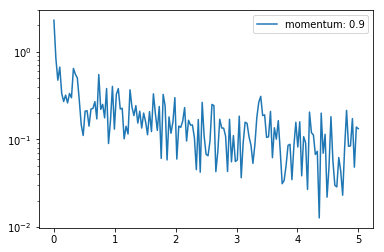

In [5]:

x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='momentum: 0.9')
plt.legend(loc='best')